In [1]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from bson.objectid import ObjectId
from gridfs import GridFS
from matplotlib.patches import Rectangle
from pymongo import MongoClient
from PIL import Image
sys.path.insert(0, '../../../models/research')
from padma.models.conteiner20e40.bbox import SSDMobileModel
from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from ajna_commons.utils.images import generate_batch, get_imagens_recortadas

db = MongoClient(host=MONGODB_URI)[DATABASE]
model = SSDMobileModel()

2019-03-27 11:29:02,571 ajna         INFO     Configuração de log efetuada


Fazendo log de erros e alertas no arquivo  /home/ivan/pybr/ajna/padma/ajna_commons/flask/error.log
Fazendo log de atividade no arquivo  /home/ivan/pybr/ajna/padma/ajna_commons/flask/access.log


In [2]:
from collections import defaultdict
def processa_detections(output_dict, batch):
    result = defaultdict(list)
    for ind, (scores, images) in enumerate(zip(output_dict['detection_scores'], batch)):
        for ind2, score in enumerate(scores):
            if score > .8:
                xfinal, yfinal = images[0].size
                bbox = [0., 0., 0., 0.]
                bbox[0] = int(output_dict['detection_boxes'][ind][ind2][0] * yfinal)
                bbox[2] = int(output_dict['detection_boxes'][ind][ind2][2] * yfinal)
                bbox[1] = int(output_dict['detection_boxes'][ind][ind2][1] * xfinal)
                bbox[3] = int(output_dict['detection_boxes'][ind][ind2][3] * xfinal)
                result[ind].append({
                    'bbox': bbox,
                    'class': output_dict['detection_classes'][ind][ind2]
                })
    return result

In [3]:
batch_size = 16
limit = 16
NAOTEMBBOX = {'metadata.contentType': 'image/jpeg',
          'metadata.predictions.bbox': {'$exists': False}}
dict_filtro = NAOTEMBBOX
projection = ['metadata.predictions']
batch_gen = generate_batch(db, filtro=dict_filtro, projection=projection,
                           batch_size=batch_size, limit=limit, recorta=False)

In [4]:
SIZE = (600, 240)
(im_width, im_height) = SIZE

def image_prepare(image):
    image = image.resize(SIZE, Image.ANTIALIAS)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

    
X = np.zeros((batch_size, im_height, im_width, 3), dtype=np.float32)
rows = []
y = []
original_images = []
s = time.time()
for batch, rows in batch_gen:
    # print(rows)
    if len(batch) == 0:
        break
    s0 = time.time()
    for i, (images, row) in enumerate(zip(batch, rows)):
        # print(images[0].size)
        original_images.append(images[0])
        image_array = image_prepare(images[0])
        s0 = time.time()
        X[i, :, :, :] = image_array
        rows.append(row)
    s1 = time.time()
    print('Montou X em %0.2f ' % (s1 - s0))
    detections = model.predict_batch(X)
    result = processa_detections(detections, batch)
    s2 = time.time()
    print('Fez predição em %s' % (s2 - s1))
    # print(indexes)
s4 = time.time()
elapsed = s4 - s
print('Tempo total: %s. Por imagem: %s' % (elapsed, elapsed / limit))


Montou X em 0.00 
Fez predição em 0.40728211402893066
Tempo total: 1.8723828792572021. Por imagem: 0.11702392995357513


In [5]:
result

defaultdict(list,
            {12: [{'bbox': [24, 33, 200, 434], 'class': 1.0}],
             13: [{'bbox': [13, 0, 190, 432], 'class': 1.0}],
             14: [{'bbox': [27, 113, 201, 329], 'class': 2.0}],
             15: [{'bbox': [10, 35, 156, 519], 'class': 1.0},
              {'bbox': [10, 42, 156, 521], 'class': 2.0}]})

In [6]:
X.shape

(16, 240, 600, 3)

In [7]:
detections

{'detection_boxes': array([[[0.03733048, 0.31144062, 0.81155217, 0.8199421 ],
         [0.        , 0.05986309, 0.86797893, 0.8550344 ]],
 
        [[0.07573631, 0.30300525, 0.8082659 , 0.74052525],
         [0.02244031, 0.15155414, 0.8149518 , 0.7638265 ]],
 
        [[0.        , 0.07582778, 0.9079321 , 0.7273011 ],
         [0.5202527 , 0.39061037, 1.        , 0.8609781 ]],
 
        [[0.03315559, 0.1371114 , 0.89311635, 0.70039845],
         [0.05303031, 0.0125389 , 0.93196946, 0.05473351]],
 
        [[0.05034116, 0.31685078, 0.8243698 , 0.8305142 ],
         [0.05580342, 0.334604  , 0.80652463, 0.74252987]],
 
        [[0.54786766, 0.11752021, 1.        , 0.63274217],
         [0.02367976, 0.12941173, 0.89610064, 0.7023488 ]],
 
        [[0.03705066, 0.18086365, 0.8369633 , 0.70286393],
         [0.4811327 , 0.03062245, 0.9752186 , 0.38193798]],
 
        [[0.0121848 , 0.15475139, 0.8555349 , 0.7223226 ],
         [0.        , 0.        , 0.7531472 , 0.5453546 ]],
 
        [[0.0

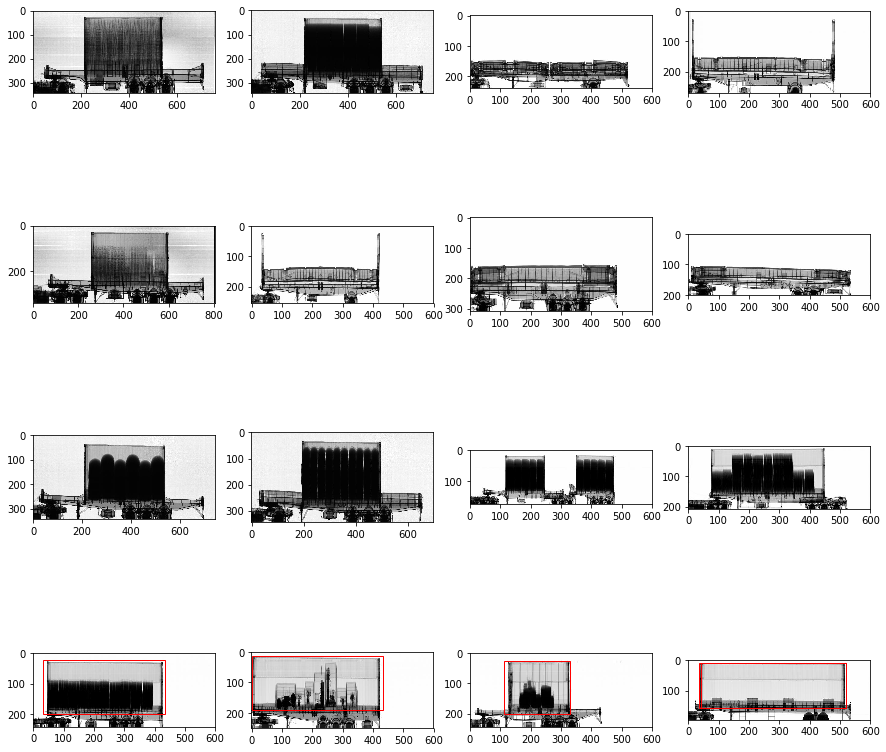

In [8]:
plt.figure(figsize=(15, 15))
for i in range(0, 16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    bbox_list = result[i]
    if bbox_list:
        #print(bbox_list)
        for item in bbox_list:
            bbox = item['bbox']
            plt.gca().add_patch(Rectangle(
                (bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], ec='r', fc='none'))


# Comparação com método 1 a 1 

In [9]:
batch_gen = generate_batch(db, filtro=dict_filtro, projection=projection,
                           batch_size=batch_size, limit=limit, recorta=False)

In [10]:
rows = []
y = []
s = time.time()
original_images = []
for batch, rows in batch_gen:
    if len(batch) == 0:
        break
    for i, (images, row) in enumerate(zip(batch, rows)):
        detection = model.predict(images[0])
        original_images.append(images[0])
        s0 = time.time()
        X[i, :, :, :] = image_array
        rows.append(row)
        y.append(detection)
s4 = time.time()
elapsed = s4 - s
print('Tempo total: %s. Por imagem: %s' % (elapsed, elapsed / limit))

Tempo total: 5.041200399398804. Por imagem: 0.31507502496242523


In [11]:
y

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [{'bbox': [24, 33, 200, 434], 'class': 1}],
 [{'bbox': [13, 0, 190, 432], 'class': 1}],
 [{'bbox': [27, 113, 201, 329], 'class': 2}],
 [{'bbox': [10, 35, 156, 520], 'class': 1},
  {'bbox': [10, 43, 155, 520], 'class': 2}]]

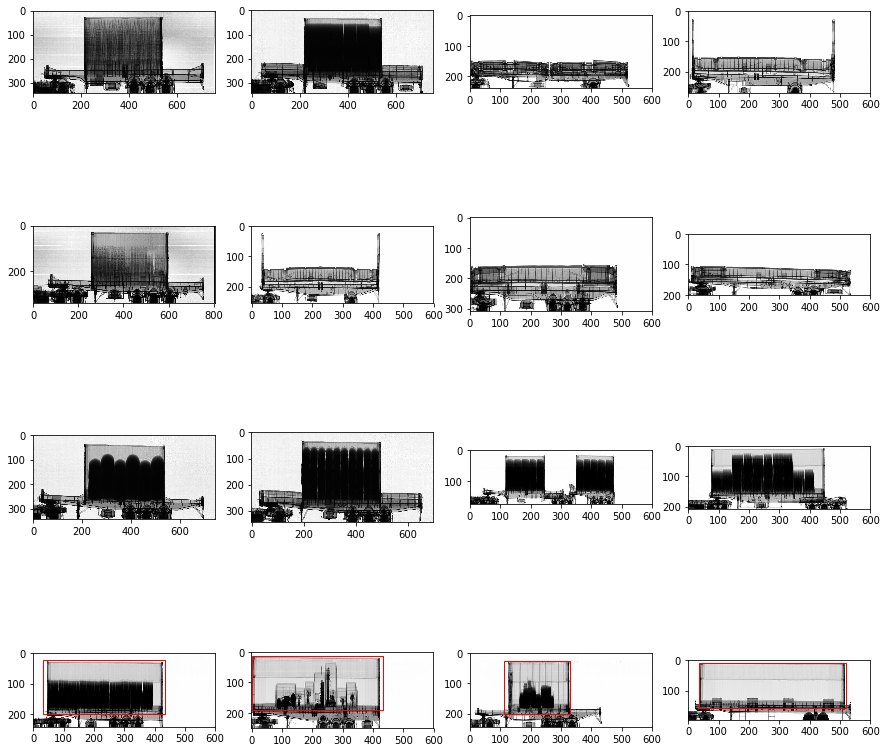

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.figure(figsize=(15, 15))
for i in range(0, 16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    bbox_list = y[i]
    if bbox_list:
        bbox = bbox_list[0]['bbox']
        plt.gca().add_patch(Rectangle(
            (bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], ec='r', fc='none'))
